# 乳腺癌检测模型

In [ ]:
import pandas as pd
import numpy as np
import re
import math
from collections import Counter
from itertools import groupby
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score,f1_score, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier #GradientBoosting
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import json
import warnings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.svm import SVC
from sklearn.linear_model.logistic import LogisticRegression
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM  #神经网络
from sklearn.pipeline import Pipeline 

## 0 数据读取

In [ ]:
## 数据格式转换（一开始的数据是txt格式的）
columns_name = ["Sample code number", "Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape","Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin","Normal Nucleoli", "Mitoses", "Class"]

dataset = pd.read_table('breast-cancer-wisconsin.txt',sep=',',names=columns_name,header=None)

temp = dataset.head(500)
train_dataset = pd.concat([temp.sample(400), dataset.iloc[500:600, :]])
shadow_dataset = pd.concat([temp.sample(400), dataset.iloc[600:699, :]])

train_dataset.to_csv("data/dataset.csv", index=None)
shadow_dataset.to_csv("data/dataset_shadow.csv", index=None)



In [ ]:
## 查看两个数据集的重复率
train_dataset = pd.read_csv("work/dataset.csv")
shadow_dataset = pd.read_csv("work/dataset_shadow.csv")
# print(len())

list1 = train_dataset["Sample code number"]
list2 = shadow_dataset["Sample code number"]

repeat_list = [e for e in list1 if e in list2.values]# 查看训练数据集中有多少元素在影子模型的训练集中
len(repeat_list)

339

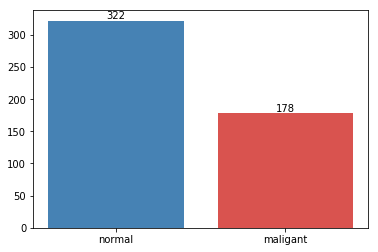

In [ ]:
#训练数据集class可视化
x = [0,1]
y = [len([e for e in train_dataset["Class"].values if e==2]),len([e for e in train_dataset["Class"].values if e==4])]
_ = plt.bar(x,y,tick_label=['normal', 'maligant'], color=["steelblue", "#d9534f"])
for a,b in zip(x,y):
    _ = plt.text(a,b,b,ha = 'center',va = 'bottom',fontsize=10)

# 目标模型部分

## 1. 数据预处理

In [ ]:
warnings.filterwarnings('ignore')
train_dataset = pd.read_csv("work/dataset.csv")
# train_dataset = pd.read_csv("data/dataset_shadow.csv")
train_dataset = train_dataset.sample(frac=1)

#替换所有的？为nan
train_dataset = train_dataset.replace('?',np.nan) 

#数据标准化处理
features_ss = train_dataset.loc[:,["Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape","Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin","Normal Nucleoli", "Mitoses"]]

ss = StandardScaler(copy=True, with_mean=True, with_std=True).fit(features_ss)
train_dataset
train_dataset.loc[:, ["Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape","Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin","Normal Nucleoli", "Mitoses"]] = ss.transform(features_ss)

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
237,1227081,3,1,1,3,2,1,1,1,1,2
438,1135090,4,1,1,1,2,1,2,1,1,2
477,695091,1,1,1,1,2,1,2,1,1,2
431,867392,4,2,2,1,2,1,2,1,1,2
428,807657,6,1,3,2,2,1,1,1,1,2
20,428903,7,2,4,1,3,4,3,3,1,4
353,1173514,1,1,1,1,4,3,1,1,1,2
111,1223426,1,1,1,1,2,1,3,1,1,2
232,560680,3,1,2,1,2,1,2,1,1,2
292,1258549,9,10,10,10,10,10,10,10,1,4


## 2 模型训练

In [14]:
# 可视化并存储预测值和标签
def plot_fig(xgbc, X_test, Y_test,X_train, Y_train):
    y_pred = xgbc.predict(X_test)
    xgbc_cm = confusion_matrix(Y_test, y_pred)
    xgbc_cr = classification_report(Y_test, y_pred)
    print(xgbc_cr)
    print("Accuracy : %.6g" % metrics.accuracy_score(Y_test.values, y_pred))
    plt.show()
    # 获取预测值,分类标签,成员标签,并保存在文件里
    y_train_pred = xgbc.predict_proba(X_train)#预测值
    t1=np.ones([len(y_train_pred),1])
    t2=np.zeros([len(y_train_pred),1])
    train_label=np.c_[t1,t2]#成员标签
    y_train_pred=np.c_[y_train_pred,Y_train]

    y_test_pred = xgbc.predict_proba(X_test)
    t3=np.zeros([len(y_test_pred),1])
    t4=np.ones([len(y_test_pred),1])
    test_label=np.c_[t3,t4]
    y_test_pred=np.c_[y_test_pred,Y_test]
    
    attack_X=[]
    attack_Y=[]
    Mattack_Y=[]
    attack_X.append(y_train_pred)
    attack_X.append(y_test_pred)
    attack_X=np.vstack(attack_X)
    attack_Y.append(train_label)
    attack_Y.append(test_label)
    attack_Y=np.vstack(attack_Y)
    Mattack_Y.append(t1)
    Mattack_Y.append(t3)
    Mattack_Y=np.vstack(Mattack_Y)

    # x_proba = clf.predict_proba(test_df)
    np.savez("work/testset.npz",attack_X,attack_Y)
    np.savez("work/Mtestset.npz",attack_X,Mattack_Y)


# 训练函数
def train(model, train_dataset):
    # 分成5次训练
    kf = KFold(n_splits=5)
    print("------------------XGBClassifier is fitting......")
    for data_train, data_test in kf.split(train_dataset):
        X_train = train_dataset.iloc[data_train, 1:-1]
        Y_train = train_dataset.iloc[data_train, -1]
        # print(len(X_train))
        X_test = train_dataset.iloc[data_test, 1:-1]
        Y_test = train_dataset.iloc[data_test, -1]
        # print(len(X_test))
        model.fit(X_train, Y_train)
        plot_fig(model, X_test, Y_test,X_train,Y_train)

    plot_importance(xgbc)
    # 模型保存
    joblib.dump(xgbc, './work/xgbc_model.pkl')

------------------XGBClassifier is fitting......
              precision    recall  f1-score   support

           2       0.97      0.98      0.98        65
           4       0.97      0.94      0.96        35

   micro avg       0.97      0.97      0.97       100
   macro avg       0.97      0.96      0.97       100
weighted avg       0.97      0.97      0.97       100

Accuracy : 0.97
              precision    recall  f1-score   support

           2       1.00      0.97      0.99        71
           4       0.94      1.00      0.97        29

   micro avg       0.98      0.98      0.98       100
   macro avg       0.97      0.99      0.98       100
weighted avg       0.98      0.98      0.98       100

Accuracy : 0.98
              precision    recall  f1-score   support

           2       1.00      0.98      0.99        55
           4       0.98      1.00      0.99        45

   micro avg       0.99      0.99      0.99       100
   macro avg       0.99      0.99      0.99    

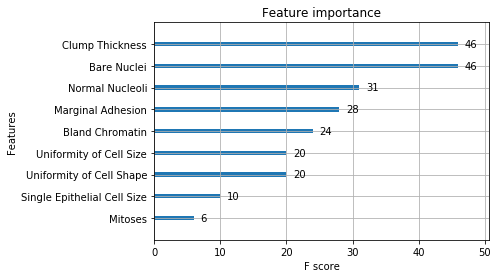

In [15]:
xgbc = XGBClassifier(objective='binary:logistic', learning_rate=0.2, max_depth=4, n_estimators=40)
train(xgbc,train_dataset)

In [6]:
# 模型调参
xgbc = XGBClassifier(objective='binary:logistic')
param_dist = {
        'n_estimators':range(40,201,20),
        'max_depth':range(4,11,2),
        'learning_rate':np.linspace(0.01,0.2,10),
        }


clf = GridSearchCV(xgbc, param_dist, cv = 5, iid=True, scoring='roc_auc', n_jobs=-1)
clf.fit(train_dataset.iloc[:,1:-1], train_dataset.iloc[:, -1]) # gridSearch自带cross_validate,所以用全部数据训练即可
np.save('./work/gridSearch.npy', clf.cv_results_)
clf.best_params_

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w...pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(40, 201, 20), 'max_depth': range(4, 11, 2), 'learning_rate': array([0.01   , 0.03111, 0.05222, 0.07333, 0.09444, 0.11556, 0.13667,
       0.15778, 0.17889, 0.2    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

{'learning_rate': 0.1788888888888889, 'max_depth': 4, 'n_estimators': 60}

## 3 API查询接口

In [ ]:
warnings.filterwarnings('ignore')
# 

from texttable import Texttable
clf=joblib.load("./work/xgbc_model.pkl")

while(1):
    print("="*100)
    print("提示：请在一行中输入包括Clump Thickness, Uniformity of Cell Size, Uniformity of Cell Shape, Marginal Adhesion, Single Epithelial Cell Size, Bare Nuclei, Bland Chromatin, Normal Nucleoli, Mitoses在内的10个指标, 仅用英文逗号隔开.\n")
    test_data = input("请输入: ")

    if test_data == "quit":
        break
    
    test_data = test_data.split(',')
    test_data = [int(e) for e in test_data]

    print("您输入的指标对应为:")
    t = Texttable()
    col_names = ["Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape", "Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin", "Normal Nucleoli", "Mitoses"]
    _ = t.add_row(["Attribute", "Domain"])
    for index in range(len(col_names)):
        _ = t.add_row([col_names[index], test_data[index]])
    print(t.draw())

    test_df= pd.DataFrame([test_data], columns=["Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape","Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin","Normal Nucleoli", "Mitoses"])
    test_df = ss.transform(test_df)

    x_proba = clf.predict_proba(test_df)
    t2 = Texttable()
    _ = t2.add_rows([["Benign", "Malignant"], [x_proba[0][0], x_proba[0][1]]])
    print("\n您的检测结果为: ")
    print(t2.draw())

提示：请在一行中输入包括Clump Thickness, Uniformity of Cell Size, Uniformity of Cell Shape, Marginal Adhesion, Single Epithelial Cell Size, Bare Nuclei, Bland Chromatin, Normal Nucleoli, Mitoses在内的10个指标, 仅用英文逗号隔开.

请输入: 您输入的指标对应为:
+-----------------------------+--------+
| Attribute                   | Domain |
+-----------------------------+--------+
| Clump Thickness             | 1      |
+-----------------------------+--------+
| Uniformity of Cell Size     | 2      |
+-----------------------------+--------+
| Uniformity of Cell Shape    | 3      |
+-----------------------------+--------+
| Marginal Adhesion           | 4      |
+-----------------------------+--------+
| Single Epithelial Cell Size | 5      |
+-----------------------------+--------+
| Bare Nuclei                 | 6      |
+-----------------------------+--------+
| Bland Chromatin             | 7      |
+-----------------------------+--------+
| Normal Nucleoli             | 8      |
+-----------------------------+--------+
| 

ValueError: feature_names mismatch: ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']
expected Uniformity of Cell Size, Normal Nucleoli, Marginal Adhesion, Clump Thickness, Uniformity of Cell Shape, Bland Chromatin, Bare Nuclei, Mitoses, Single Epithelial Cell Size in input data
training data did not have the following fields: f3, f4, f6, f0, f1, f8, f2, f5, f7

# 阴影模型部分
**1.数据预处理**

In [5]:
warnings.filterwarnings('ignore')
train_dataset1 = pd.read_csv("work/dataset_shadow.csv")
train_dataset1= train_dataset1.sample(frac=1)

#替换所有的？为'0'
train_dataset1 = train_dataset1.replace('?','0') 

#数据标准化处理
features_ss1 = train_dataset1.loc[:,["Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape","Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin","Normal Nucleoli", "Mitoses"]]

ss1 = StandardScaler(copy=True, with_mean=True, with_std=True).fit(features_ss1)
# train_dataset
train_dataset1.loc[:, ["Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape","Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin","Normal Nucleoli", "Mitoses"]] = ss1.transform(features_ss1)

In [7]:
# 搭建阴影模型,因为不知道哪个最接近,所以都搭建
def classifier1():
    clf = SVC(C=0.5,                         #误差项惩罚系数,默认值是1
                  kernel='linear',               #线性核 kenrel="rbf":高斯核
                  decision_function_shape='ovo')
    return clf

def classifier2():
    clf = RandomForestClassifier(n_estimators=100)
    return clf

def classifier3():
    #迭代100次 ,学习率为0.1
    clf = AdaBoostClassifier(n_estimators=100,learning_rate=0.2)
    return clf

def classifier4():
    #迭代100次 ,学习率为0.1
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
    return clf

def classifier5():
    logistic = linear_model.LogisticRegression()  
    rbm = BernoulliRBM(random_state=0, verbose=True)  
    clf = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])  
    rbm.learning_rate = 0.1
    rbm.n_iter = 20   
    rbm.n_components = 100  
    #正则化强度参数
    logistic.C = 10   
    return clf

def classifier6():
    clf = XGBClassifier(max_depth=3, n_estimators=100, learn_rate=0.1)
    return clf

def classifier7():
    clf = linear_model.LogisticRegression()    # logistic回归
    return clf 

# 训练函数
# def train(clf,x_train,y_train):
#     clf.fit(x_train,y_train.ravel())#ravel()将多维数据降成一维

# 打印准确率和召回率
def print_accuracy(clf,x_train,y_train,x_test,y_test):
    #分别打印训练集和测试集的准确率  score(x_train,y_train):表示输出x_train,y_train在模型上的准确率
    print('trianing prediction:%.6f' %(clf.score(x_train, y_train)))
    print('testing prediction:%.6f' %(clf.score(x_test, y_test)))
    # print("train_data recall:%.6f"%recall_score(clf.predict(x_train), y_train))
    # print("test_data recall:%.6f"%recall_score(clf.predict(x_test), y_test))
    test_pre=clf.predict(x_test)
    cnt=0
    for i in range(len(test_pre)):
        if test_pre[i]==y_test[i]:
            cnt+=1
    print("漏报率:",1-cnt/len(test_pre))
    print("误报率:",(len(test_pre)-cnt)/len(y_test))
    target_names=['normal','malicious']
    print(classification_report(y_test, clf.predict(x_test), target_names=target_names))
    print("\n")

#定义好分类模型
clf1=classifier1()
clf2=classifier2()
clf3=classifier3()
clf4=classifier4()
# clf5=classifier5()
clf6=classifier6()
clf7=classifier7()


def shadowTrain(targetclf,shadowclf,train_dataset,num=5):
    # num是阴影模型的个数，越多得到的训练数据越多
    for i in range(num):
        kf = KFold(n_splits=2)
        for data_train, data_test in kf.split(train_dataset):
                x_train = train_dataset.iloc[data_train, 1:-1]
                y_train = targetclf.predict(x_train)
               
                x_test = train_dataset.iloc[data_test, 1:-1]
                y_test = targetclf.predict(x_test)
            
                shadowclf.fit(x_train,y_train)
                print_accuracy(shadowclf,x_train,y_train,x_test,y_test)

def shadowfile(shadowclf, X_test, Y_test,X_train, Y_train):
    # 获取预测值,分类标签,成员标签,并保存在文件里
    y_train_pred = shadowclf.predict_proba(X_train)#预测值
    train_label=np.ones(len(y_train_pred))#成员标签
    y_train_pred=np.c_[y_train_pred,Y_train,train_label]

    y_test_pred = shadowclf.predict_proba(X_test)
    test_label=np.zeros(len(y_test_pred))
    y_test_pred=np.c_[y_test_pred,Y_test,test_label]
    # x_proba = clf.predict_proba(test_df)
    # print("y_train_pred[0]")
    # print(y_train_pred[0])
    # print("y_test_pred[0]")
    # print(y_test_pred[0])
    np.savez("work/trainset.npz",y_train_pred,y_test_pred)


In [8]:
# 选择最相似的阴影模型
print("SVM:") 
shadowTrain(clf,clf1,train_dataset1,num=1)
print("RandomForest:")
shadowTrain(clf,clf2,train_dataset1,num=1)
print("AdaBoost:") 
shadowTrain(clf,clf3,train_dataset1,num=1)
print("GradientBoosting:")
shadowTrain(clf,clf4,train_dataset1,num=1)
print("xgboost:")
shadowTrain(clf,clf6,train_dataset1,num=1)
print("LogisticRegression:")
shadowTrain(clf,clf7,train_dataset1,num=1)
# 最好的效果是xgboost和GradientBoosting

SVM:
trianing prediction:0.983936
testing prediction:0.972000
漏报率: 0.028000000000000025
误报率: 0.028
              precision    recall  f1-score   support

      normal       0.99      0.96      0.98       170
   malicious       0.93      0.99      0.96        80

   micro avg       0.97      0.97      0.97       250
   macro avg       0.96      0.98      0.97       250
weighted avg       0.97      0.97      0.97       250



trianing prediction:0.976000
testing prediction:0.971888
漏报率: 0.028112449799196804
误报率: 0.028112449799196786
              precision    recall  f1-score   support

      normal       0.96      0.99      0.98       155
   malicious       0.99      0.94      0.96        94

   micro avg       0.97      0.97      0.97       249
   macro avg       0.98      0.96      0.97       249
weighted avg       0.97      0.97      0.97       249



RandomForest:
trianing prediction:1.000000
testing prediction:0.972000
漏报率: 0.028000000000000025
误报率: 0.028
              precision   

In [9]:
# 开始训练阴影模型，并保存数据
def shadowTrain2(targetclf,shadowclf,train_dataset,num=10):
    # num是阴影模型的个数，越多得到的训练数据越多
    attack_X=[]
    attack_Y=[]
    Mattack_Y=[]
    for i in range(num):
        kf = KFold(n_splits=5)
        for data_train, data_test in kf.split(train_dataset):
                x_train = train_dataset.iloc[data_train, 1:-1]
                y_train = targetclf.predict(x_train)
                # print(len(x_train))
                x_test = train_dataset.iloc[data_test, 1:-1]
                y_test = targetclf.predict(x_test)
                # print(len(x_test))
                shadowclf.fit(x_train,y_train)
                attack_X_tmp,attack_Y_tmp,Mattack_Y_tmp=shadowfile(shadowclf,x_test,y_test,x_train,y_train)
                attack_X.append(attack_X_tmp)
                attack_Y.append(attack_Y_tmp)
                Mattack_Y.append(Mattack_Y_tmp)
    attack_X=np.vstack(attack_X)
    attack_Y=np.vstack(attack_Y)
    Mattack_Y=np.vstack(Mattack_Y)
    np.savez("work/trainset.npz",attack_X,attack_Y)
    np.savez("work/Mtrainset.npz",attack_X,Mattack_Y)

def shadowfile(shadowclf, X_test, Y_test,X_train, Y_train):
    # 获取预测值,分类标签,成员标签,并保存在文件里
    y_train_pred = shadowclf.predict_proba(X_train)#预测值
    t1=np.ones([len(y_train_pred),1])
    t2=np.zeros([len(y_train_pred),1])
    train_label=np.c_[t1,t2]#成员标签
    y_train_pred=np.c_[y_train_pred,Y_train]

    y_test_pred = shadowclf.predict_proba(X_test)
    t3=np.zeros([len(y_test_pred),1])
    t4=np.ones([len(y_test_pred),1])
    test_label=np.c_[t3,t4]#成员标签
    y_test_pred=np.c_[y_test_pred,Y_test]
    
    attack_X=[]
    attack_Y=[]
    Mattack_Y=[]
    attack_X.append(y_train_pred)
    attack_X.append(y_test_pred)
    attack_X=np.vstack(attack_X)

    attack_Y.append(train_label)
    attack_Y.append(test_label)
    attack_Y=np.vstack(attack_Y)

    Mattack_Y.append(t1)
    Mattack_Y.append(t3)
    Mattack_Y=np.vstack(Mattack_Y)
    # x_proba = clf.predict_proba(test_df)
    return attack_X,attack_Y,Mattack_Y
# 用的GradientBoosting
shadowTrain2(clf,clf4,train_dataset1,num=10)

# shadowTrain(clf,clf6,train_dataset1,num=1) #xgb

# 攻击模型部分
用机器学习

In [10]:
def train_attack_model(dataset):
    x_train,y_train,x_test, y_test = dataset
    clf1.fit(x_train,y_train)
    clf2.fit(x_train,y_train)
    clf3.fit(x_train,y_train)
    clf4.fit(x_train,y_train)
    clf6.fit(x_train,y_train)
    clf7.fit(x_train,y_train)
    

    #模型评估
    print("SVM:")  
    print_accuracy(clf1,x_train,y_train,x_test,y_test)
    print("RandomForest:")
    print_accuracy(clf2,x_train,y_train,x_test,y_test)
    print("AdaBoost:")  
    print_accuracy(clf3,x_train,y_train,x_test,y_test)
    print("GradientBoosting:")
    print_accuracy(clf4,x_train,y_train,x_test,y_test)
    # print("neural_network:")  
    # print_accuracy(clf5,x_train,y_train,x_test,y_test)
    print("xgboost:")
    print_accuracy(clf6,x_train,y_train,x_test,y_test)
    print("LogisticRegression:")
    print_accuracy(clf7,x_train,y_train,x_test,y_test)

    #绘制特征的重要性
    # from xgboost import plot_importance
    # plot_importance(clf6)
    # plt.show()


# 加载数据集
def load_attack_data(attack_train,attack_test):
    fname = attack_train
    with np.load(fname) as f:
        train_x, train_y = [f['arr_%d' % i] for i in range(len(f.files))]
    fname = attack_test
    with np.load(fname) as f:
        test_x, test_y = [f['arr_%d' % i] for i in range(len(f.files))]
    # 打乱数据
    index1 = [i for i in range(len(train_x))]
    index2 = [i for i in range(len(test_x))] 
    np.random.seed(12)
    np.random.shuffle(index1) # 打乱索引
    np.random.seed(13)
    np.random.shuffle(index2)
    train_x = train_x[index1]
    train_y = train_y[index1]
    test_x = test_x[index2]
    test_y = test_y[index2]
    return train_x.astype('float32'), train_y.astype('int32'), test_x.astype('float32'), test_y.astype('int32')

    
print ('-' * 10 + 'TRAIN ATTACK' + '-' * 10 + '\n')
attack_train_x, attack_train_y, attack_test_x, attack_test_y=load_attack_data("work/Mtrainset.npz","work/Mtestset.npz")
dataset = (attack_train_x, attack_train_y, attack_test_x, attack_test_y)
train_attack_model(dataset=dataset)

----------TRAIN ATTACK----------

SVM:
trianing prediction:0.800000
testing prediction:0.800000
漏报率: 0.19999999999999996
误报率: 0.2
              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       100
   malicious       0.80      1.00      0.89       400

   micro avg       0.80      0.80      0.80       500
   macro avg       0.40      0.50      0.44       500
weighted avg       0.64      0.80      0.71       500



RandomForest:
trianing prediction:0.878156
testing prediction:0.680000
漏报率: 0.31999999999999995
误报率: 0.32
              precision    recall  f1-score   support

      normal       0.22      0.23      0.22       100
   malicious       0.80      0.79      0.80       400

   micro avg       0.68      0.68      0.68       500
   macro avg       0.51      0.51      0.51       500
weighted avg       0.69      0.68      0.68       500



AdaBoost:
trianing prediction:0.800000
testing prediction:0.800000
漏报率: 0.19999999999999996
误报率: 0.2
     

In [ ]:
# xgbc = XGBClassifier(objective='binary:logistic')
param_dist1 = {
        'n_estimators':range(40,201,10)
        # 'max_depth':range(4,11,2),
        # 'learning_rate':np.linspace(0.01,0.2,10),
        }


attackclf = GridSearchCV(clf2, param_dist1, cv = 5, iid=True, scoring='roc_auc', n_jobs=-1)
attackclf.fit(attack_train_x, attack_train_y) # gridSearch自带cross_validate,所以用全部数据训练即可
np.save('./work/gridSearch2.npy', clf.cv_results_)
attackclf.best_params_
print("RandomForest:")
print_accuracy(attackclf,attack_train_x, attack_train_y, attack_test_x, attack_test_y)

In [16]:
# 再试试用全连接网络
from  work.attack import train as attack_model
attack_train_x1,attack_train_y1,attack_test_x1,attack_test_y1=load_attack_data("work/trainset.npz","work/testset.npz")
dataset = (attack_train_x1, attack_train_y1, attack_test_x1, attack_test_y1)
acc= attack_model(dataset,epochs=500, learning_rate=0.01)

Building model with 24950 training data, 2 classes...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
train epoch 0:
[5.045484, 0.42316633]
train epoch 5:
[4.1245623, 0.5218036]
train epoch 10:
[3.3081493, 0.54977953]
train epoch 15:
[2.6748667, 0.5934269]
train epoch 20:
[2.1795814, 0.6282966]
train epoch 25:
[1.8307916, 0.6456112]
train epoch 30:
[1.52711, 0.6651703]
train epoch 35:
[1.3163058, 0.69266534]
train epoch 40:
[1.138999, 0.7079759]
train epoch 45:
[1.0392185, 0.7261723]
train epoch 50:
[0.9483713, 0.7402004]
train epoch 55:
[0.91780186, 0.7468537]
train epoch 60:
[0.8570015, 0.757515]
train epoch 65:
[0.8253831, 0.76008016]
train epoch 70:
[0.79527605, 0.765491]
train epoch 75:
[0.774076, 0.7700601]
train epoch 80:
[0.76283514, 0.77162325]
train epoch 85:
[0.74433225, 0.77182364]
train epoch 90:
[0.7426217, 0.7760321]
train epoch 95:
[0.7374828, 0.7775551]
train epoch 100:
[0.7272033, 0.7788377]
train epoc

In [ ]:
warnings.filterwarnings('ignore')
# 

from texttable import Texttable
clf=joblib.load("./work/xgbc_model.pkl")

while(1):
    print("="*100)
    print("提示：请在一行中输入包括Clump Thickness, Uniformity of Cell Size, Uniformity of Cell Shape, Marginal Adhesion, Single Epithelial Cell Size, Bare Nuclei, Bland Chromatin, Normal Nucleoli, Mitoses在内的10个指标, 仅用英文逗号隔开.\n")
    test_data = input("请输入: ")

    if test_data == "quit":
        break
    
    test_data = test_data.split(',')
    test_data = [int(e) for e in test_data]

    print("您输入的指标对应为:")
    t = Texttable()
    col_names = ["Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape", "Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin", "Normal Nucleoli", "Mitoses"]
    _ = t.add_row(["Attribute", "Domain"])
    for index in range(len(col_names)):
        _ = t.add_row([col_names[index], test_data[index]])
    print(t.draw())

    test_df= pd.DataFrame([test_data], columns=["Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape","Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin","Normal Nucleoli", "Mitoses"])
    test_df = ss.transform(test_df)

    x_proba = clf.predict_proba(test_df)
    t2 = Texttable()
    _ = t2.add_rows([["Benign", "Malignant"], [x_proba[0][0], x_proba[0][1]]])
    print("\n您的检测结果为: ")
    print(t2.draw())
# 这里我是仿造前面部分写的，但是输入10个指标或者8个指标都报错，不知道什么原因
    label=input("请输入对应真实标签: ")
    x_proba.append(label)
    x1_proba=attackclf.predic_proba(x_proba)
    t3 = Texttable()
    _ = t3.add_rows([["member", "nomember"], [x1_proba[0][0], x1_proba[0][1]]])
    print("\n身份结果为: ")
    print(t3.draw())


提示：请在一行中输入包括Clump Thickness, Uniformity of Cell Size, Uniformity of Cell Shape, Marginal Adhesion, Single Epithelial Cell Size, Bare Nuclei, Bland Chromatin, Normal Nucleoli, Mitoses在内的10个指标, 仅用英文逗号隔开.

请输入: 您输入的指标对应为:
+-----------------------------+--------+
| Attribute                   | Domain |
+-----------------------------+--------+
| Clump Thickness             | 0      |
+-----------------------------+--------+
| Uniformity of Cell Size     | 1      |
+-----------------------------+--------+
| Uniformity of Cell Shape    | 2      |
+-----------------------------+--------+
| Marginal Adhesion           | 3      |
+-----------------------------+--------+
| Single Epithelial Cell Size | 4      |
+-----------------------------+--------+
| Bare Nuclei                 | 5      |
+-----------------------------+--------+
| Bland Chromatin             | 6      |
+-----------------------------+--------+
| Normal Nucleoli             | 7      |
+-----------------------------+--------+
| 

ValueError: feature_names mismatch: ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']
expected Uniformity of Cell Size, Normal Nucleoli, Marginal Adhesion, Clump Thickness, Uniformity of Cell Shape, Bland Chromatin, Bare Nuclei, Mitoses, Single Epithelial Cell Size in input data
training data did not have the following fields: f3, f4, f6, f0, f1, f8, f2, f5, f7